# Check relief

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
path = '/home/lalandmi/data/landice_relief/'

In [73]:
relief = xr.open_dataarray(path+'Relief.nc').rename({'latitude': 'lat', 'longitude': 'lon'})
relief_new = xr.open_dataarray(path+'Relief_new.nc').rename({'LATITUDE': 'lat', 'LONGITUDE': 'lon'})
gmted = xr.open_dataarray(path+'../Relief/Relief_GMTED2010_15n015_00625deg.nc').rename({'latitude': 'lat', 'longitude': 'lon'})

In [66]:
u.deg2km(2160, 1080, 0)

{'x': 18.532487774093124, 'y': 18.532487774093124, 'units': 'km'}

In [68]:
u.deg2km(5760, 2880, 0)

{'x': 6.949682915284921, 'y': 6.949682915284921, 'units': 'km'}

In [69]:
360/5760

0.0625

In [70]:
360/2160

0.16666666666666666

In [74]:
relief

<xarray.DataArray 'RELIEF' (lat: 1080, lon: 2160)>
[2332800 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -179.9167 -179.75 -179.5833 ... 179.75 179.9167
  * lat      (lat) float32 89.91655 89.74982 89.58309 ... -89.74982 -89.91655
Attributes:
    units:     m
    title:     RELIEF
    lon_name:  RELIEF

In [75]:
relief_new

<xarray.DataArray 'relief' (lat: 2880, lon: 5760)>
[16588800 values with dtype=float64]
Coordinates:
  * lon      (lon) float32 -179.96875 -179.90625 ... 179.90625 179.96875
  * lat      (lat) float32 -89.96875 -89.90625 -89.84375 ... 89.90625 89.96875
Attributes:
    long_name:  IF SOURCE_INTERP GT 1 THEN SURFACE_INTERP ELSE RELIEF[D=1]

In [76]:
gmted

<xarray.DataArray 'RELIEF' (lat: 2880, lon: 5760)>
[16588800 values with dtype=int16]
Coordinates:
  * lat      (lat) float32 -89.96875 -89.90625 -89.84375 ... 89.90625 89.96875
  * lon      (lon) float32 -179.96875 -179.90625 ... 179.90625 179.96875
Attributes:
    units:     m
    title:     RELIEF
    lon_name:  RELIEF

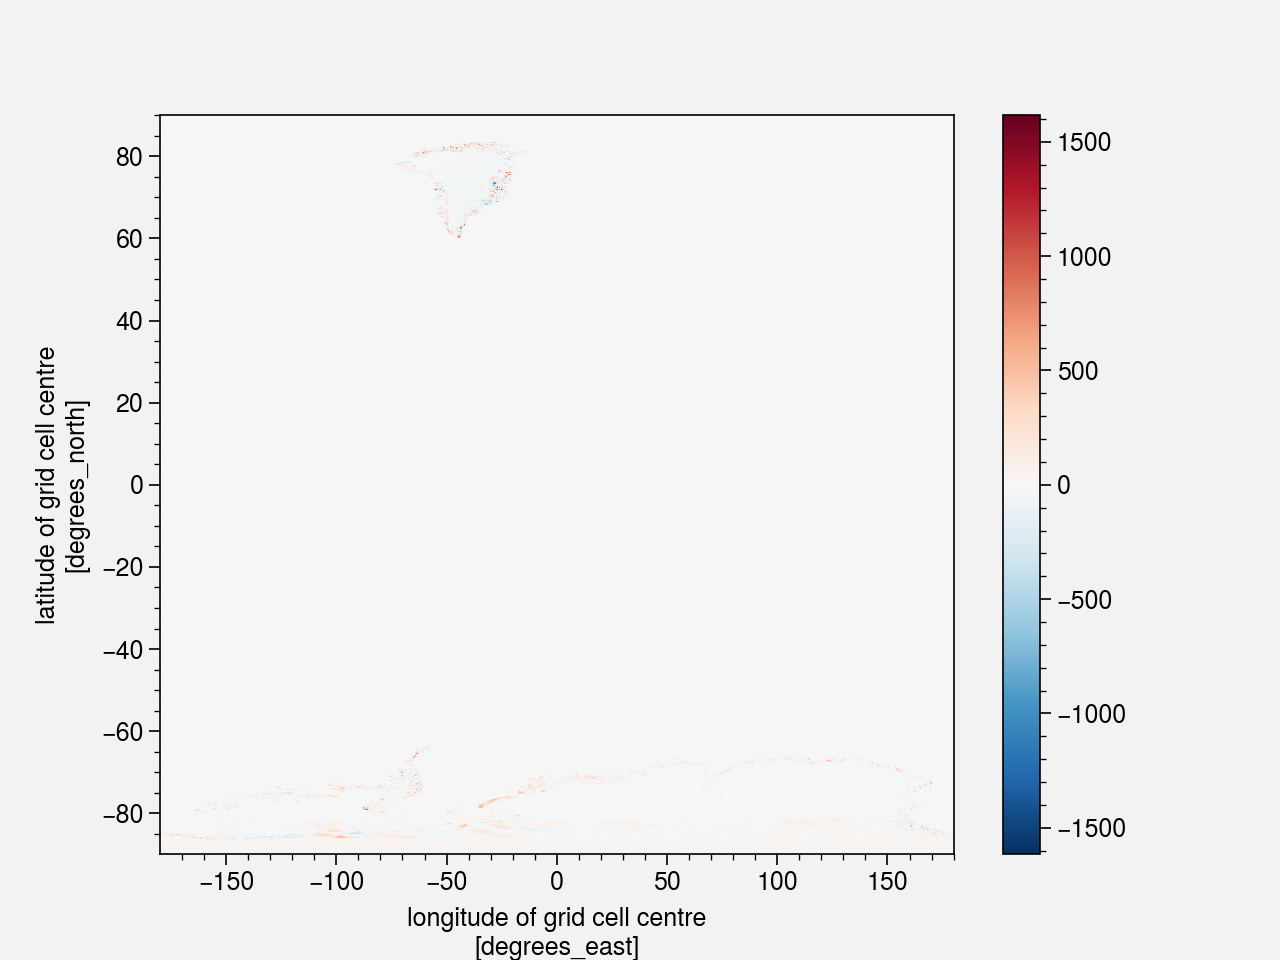

In [64]:
(relief_new - gmted).plot()

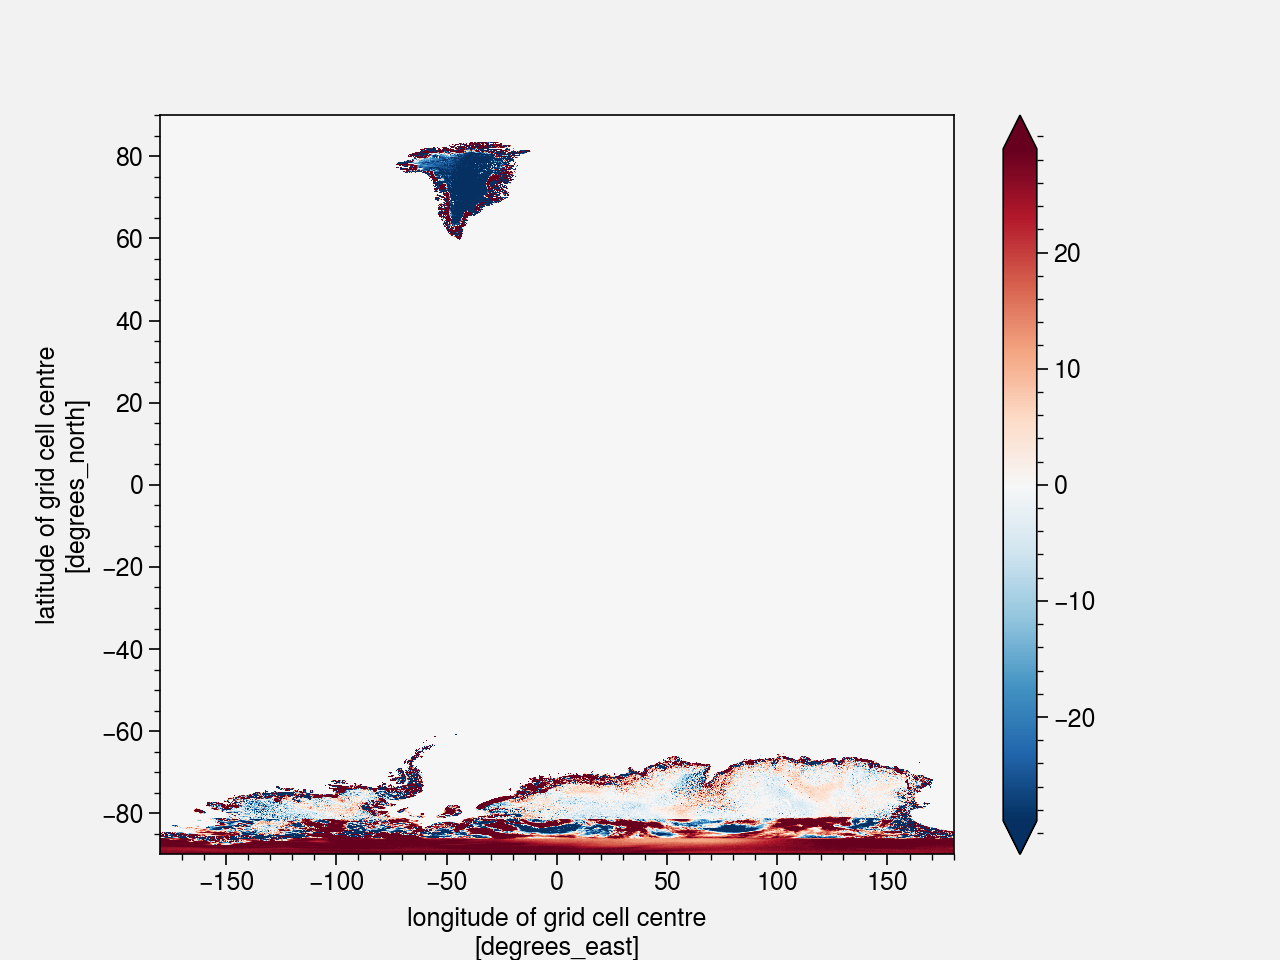

In [56]:
(relief_new - gmted).plot(robust=True)

In [57]:
(relief_new - gmted).min()

<xarray.DataArray ()>
array(-1501.78812027)

In [58]:
(relief_new - gmted).max()

<xarray.DataArray ()>
array(1616.18157196)

In [77]:
regridder = xe.Regridder(relief_new, relief, 'bilinear', periodic=True, reuse_weights=True)
relief_new_regrid = regridder(relief_new)

Create weight file: bilinear_2880x5760_1080x2160_peri.nc


In [83]:
regridder = xe.Regridder(gmted, relief, 'bilinear', periodic=True, reuse_weights=True)
gmted_regrid = regridder(gmted)

Reuse existing file: bilinear_2880x5760_1080x2160_peri.nc


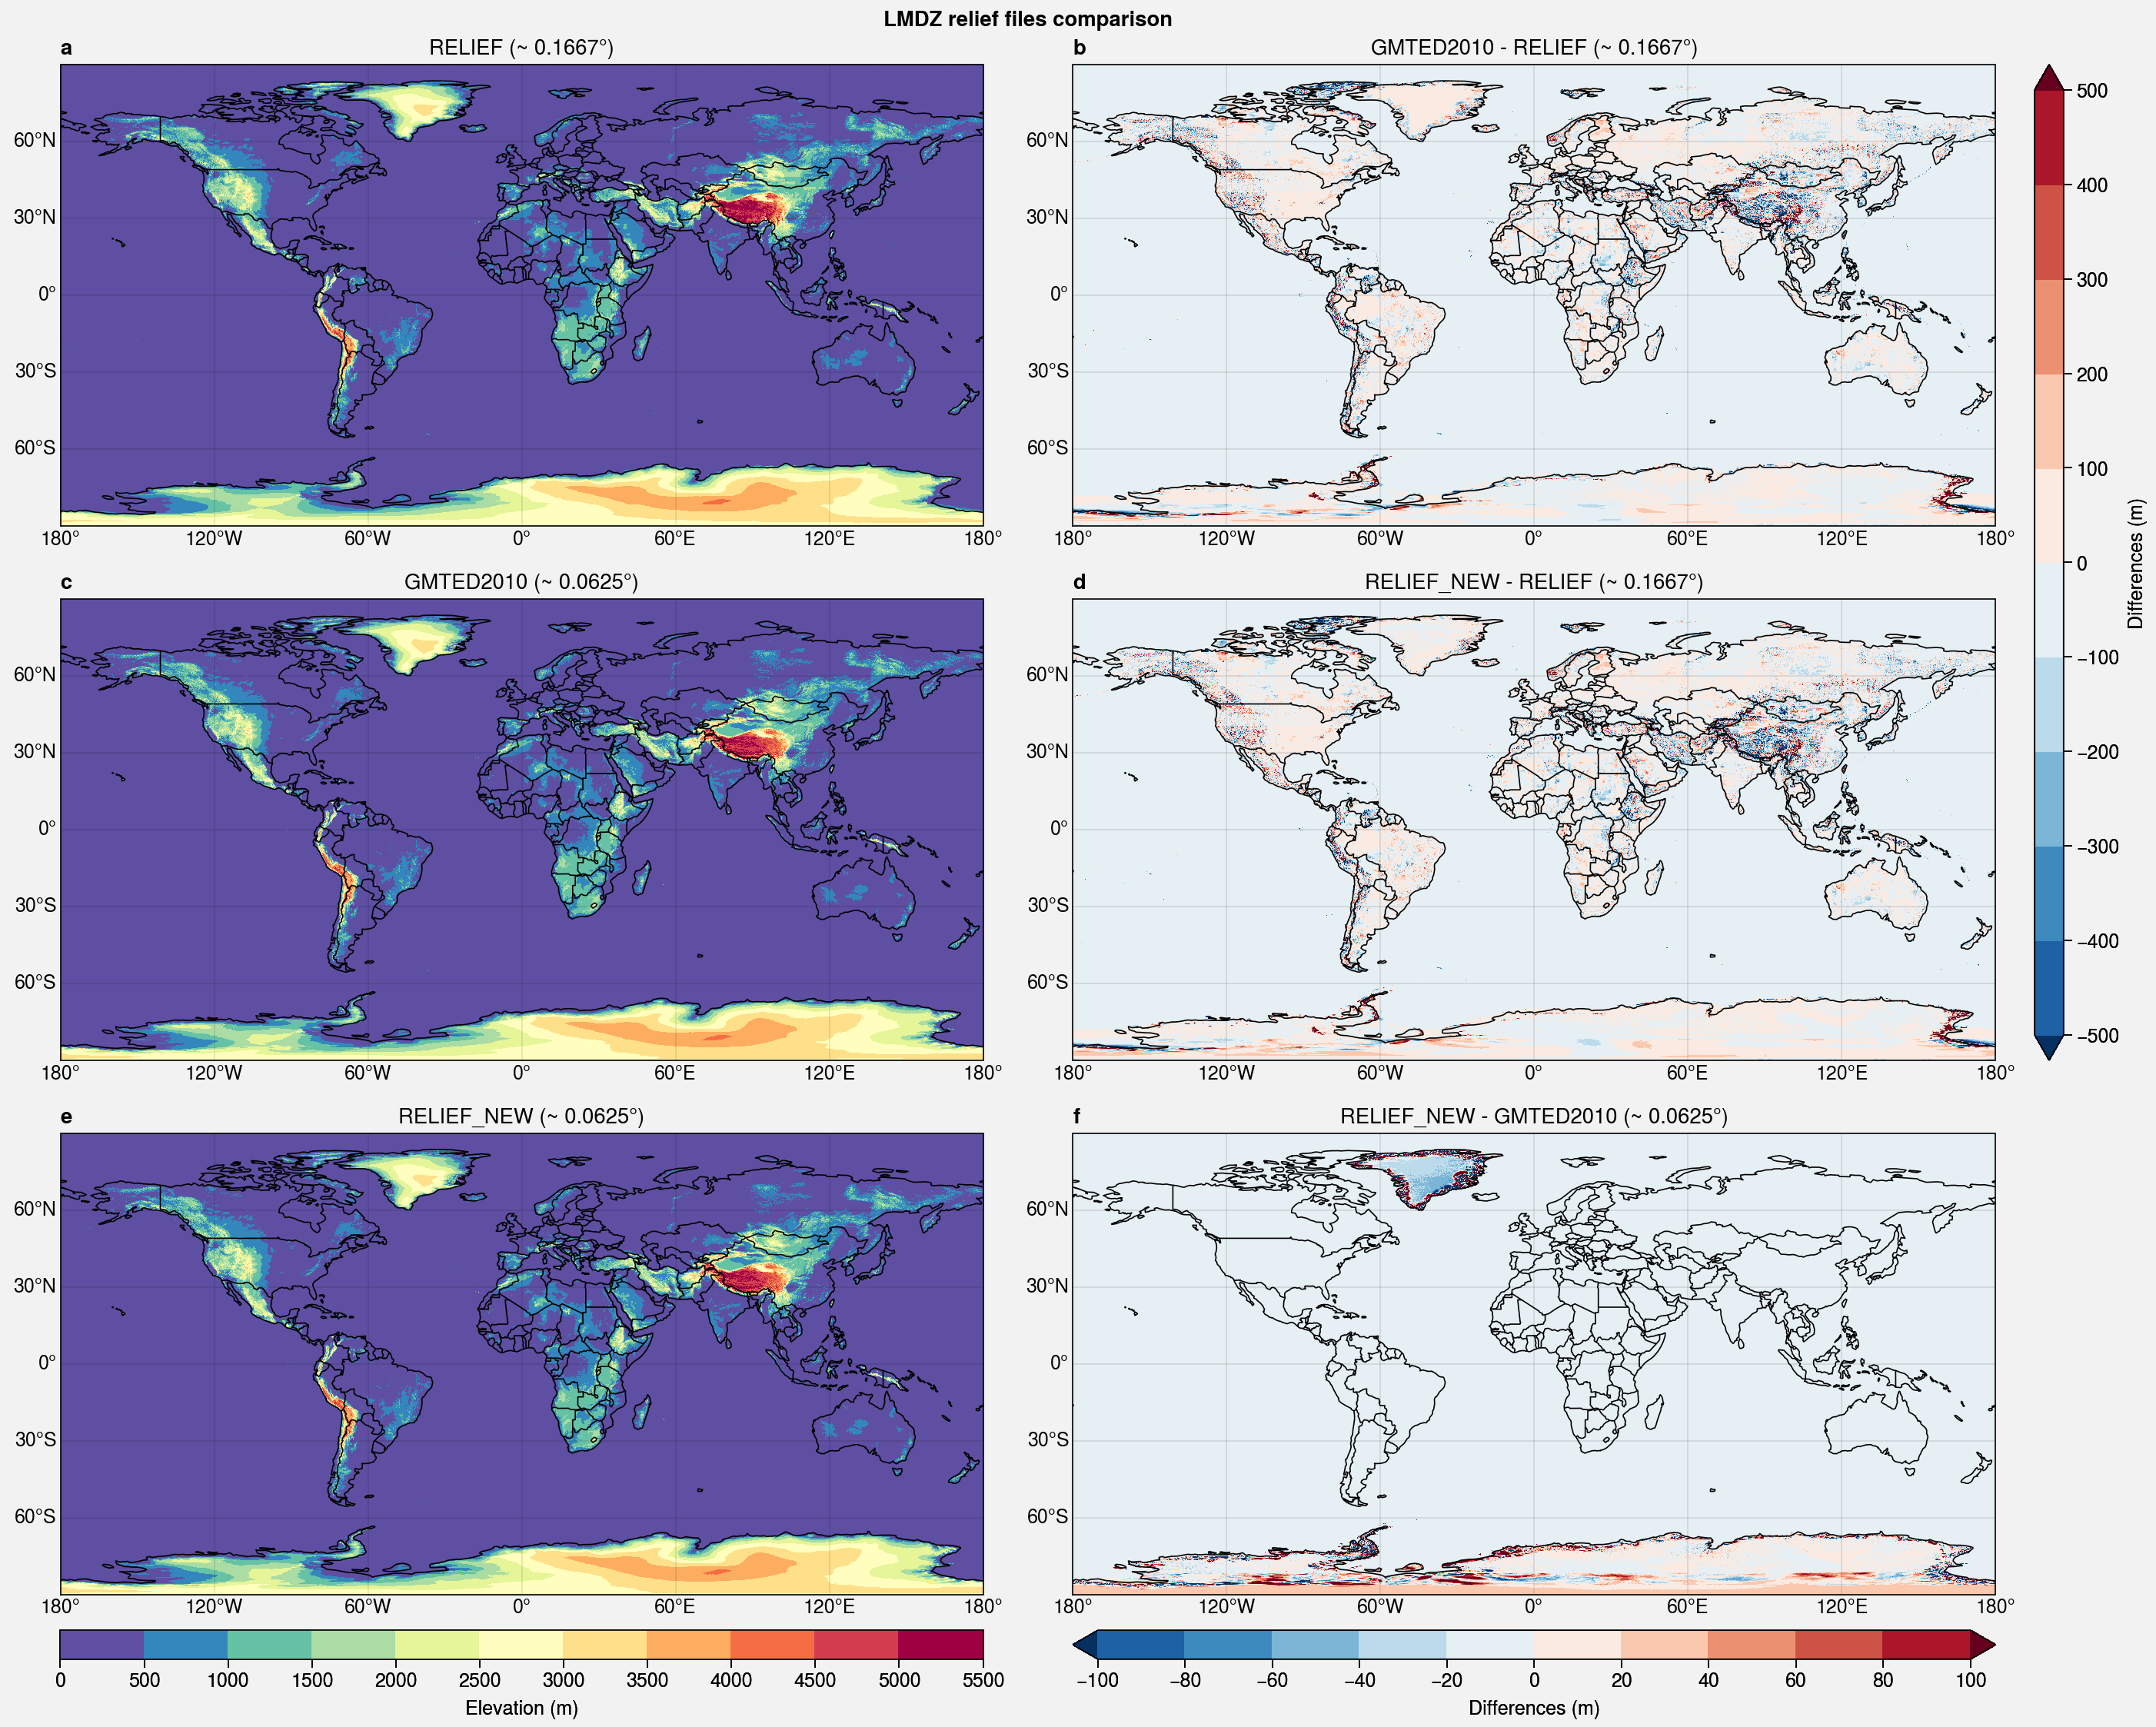

In [89]:
levels=plot.arange(0,5500,500)
cmap='Spectral_r'
extend='neither'

levels_bias=plot.arange(-100,100,20)
levels_bias_2=plot.arange(-500,500,100)
cmap_bias='BuRd'
extend_bias='both'

f, axs = plot.subplots(proj='cyl', ncols=2, nrows=3, axwidth=6)

axs[0].pcolormesh(relief, levels=levels, cmap=cmap, extend=extend)
axs[0].format(title='RELIEF (~ 0.1667°)')

axs[1].pcolormesh((gmted_regrid-relief), levels=levels_bias_2, cmap=cmap_bias, extend=extend_bias)
axs[1].format(title='GMTED2010 - RELIEF (~ 0.1667°)')

axs[2].pcolormesh(gmted, levels=levels, cmap=cmap, extend=extend)
axs[2].format(title='GMTED2010 (~ 0.0625°)')

m3 = axs[3].pcolormesh((relief_new_regrid-relief), levels=levels_bias_2, cmap=cmap_bias, extend=extend_bias)
axs[3].format(title='RELIEF_NEW - RELIEF (~ 0.1667°)')
# axs[3].colorbar(m3, label='Differences (m)', loc='b')
f.colorbar(m3, label='Differences (m)', rows=(1, 2))

m4 = axs[4].pcolormesh(relief_new, levels=levels, cmap=cmap, extend=extend)
axs[4].format(title='RELIEF_NEW (~ 0.0625°)')
axs[4].colorbar(m4, label='Elevation (m)', loc='b')

m5 = axs[5].pcolormesh((relief_new-gmted), levels=levels_bias, cmap=cmap_bias, extend=extend_bias)
axs[5].format(title='RELIEF_NEW - GMTED2010 (~ 0.0625°)')
axs[5].colorbar(m5, label='Differences (m)', loc='b')


axs.format(
    labels=True, borders=True, coast=True, abc=True,
    suptitle='LMDZ relief files comparison'
)

f.save('img/relief_new-gmted.jpg')